<h2>Agente criador de música sertaneja - SertanejoMachine</h2>

Este notebook exemplifica a criação de um agente inteligente que gera letras de músicas a partir de uma corpora. Neste caso, foi escolhido o gênero Sertanejo, por possuir uma diversidade de vocabulário mais simples. Isso facilita o processo de modelagem no sentido de que com poucos exemplos podemos criar uma rede neural que entenda a lógica sequencial das palavras de cada sentança.

<h3>Crawler de letras de músicas</h3>

O site escolhido para obtenção dos dados foi o letras.mus.br, por organizar de maneira simplificada as músicas mais buscadas por gênero, em uma lista suficientemente grande

In [1]:
# -*- coding:utf-8 -*-
import requests
from multiprocessing import Pool
from pyquery import PyQuery
from tqdm import tqdm

BASE_URL = "https://www.letras.mus.br"
SERTANEJO_TOP = "/mais-acessadas/sertanejo/"

# Captura a página onde estão listadas as músicas do top 1000
def get_top1000_page():
    retry = 3
    response = None
    while(retry):
        try:
            response = requests.get(BASE_URL + SERTANEJO_TOP)
            if 200 <= response.status_code < 300:
                break
            else:
                retry -= 1
        except:
            retry -= 1
    return response

# Faz o parsing na página das músicas do top 1000 e extrai todas as hrefs de letras
def get_top1000_urls(response):
    pq = PyQuery(response.text)
    hrefs = [i.attr('href') for i in pq('ol.top-list_mus.cnt-list--col1-3 a').items()]
    return hrefs

# Captura a página da música e extrai as informações de título, interprete e letra
def fetch_lyrics(url):
    retry = 3
    response = None
    while(retry):
        try:
            response = requests.get(BASE_URL + url)
            if 200 <= response.status_code < 300:
                break
            else:
                retry -= 1
        except:
            retry -= 1
            
    pq = PyQuery(response.text)
    title, artist = pq('div.cnt-head_title').text().split('\n')
    lyrics = pq('div.cnt-letra.p402_premium').text()
    return (title, artist, lyrics)


# Processamento paralelo utilizando um Pool de threads
def mmap(function, iterable):
    p = Pool()
    result = list(tqdm(p.imap(function, iterable), total=len(iterable)))
    p.close()
    return result

resp = get_top1000_page()
hrefs = get_top1000_urls(resp)
title_artist_lyrics = mmap(fetch_lyrics, hrefs)

100%|██████████| 1000/1000 [00:03<00:00, 300.60it/s]


<h3>Processamento dos dados coletados</h3>

Executa a rotina de transformação das tuplas em uma matriz de tokens

In [2]:
# Transformação das tuplas em um Dataframe
import pandas as pd
songs = pd.DataFrame(title_artist_lyrics, columns=["title", "artist", "lyrics"])
songs.head()

,title,artist,lyrics
0,Notificação Preferida,Zé Neto e Cristiano,Já doeu\nMas hoje não dói mais\nTanto fiz\nQue...
1,Bebida na Ferida,Zé Neto e Cristiano,Parecia um bom negócio\nVocê se desfazer de mi...
2,Atrasadinha (part. Ferrugem),Felipe Araújo,Botei a melhor roupa pra esconder os meus defe...
3,Safadômetro,Thiago Matheus,Sou um cara apaixonado\nSou um homem prendado\...
4,Vingança (part. MC Kekel),Luan Santana,"Não vou mais pensar em você\nNa minha mente, c..."


In [4]:
import ftfy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Corrige problemas causados por codificação dos caracteres
songs['lyrics'] = [ftfy.fix_text(l).lower() for l in songs.lyrics.values]

# Concatena os textos para um único objeto
corpora = " ".join(songs.lyrics.values)

# Criação dos tokens e do encoder a partir da corpora
tokenizer = Tokenizer()
tokenizer.fit_on_texts([corpora])
encoded = tokenizer.texts_to_sequences([corpora])[0]

# Tamanho do vocabulário
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# Codifica um bigrama para um unigrama 
sequences = list()
for i in range(2, len(encoded)):
    sequence = encoded[i-2:i+1]
    sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

# Faz o padding das sequências
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)

Using TensorFlow backend.


Vocabulary Size: 8379
Total Sequences: 190712
Max Sequence Length: 3


<h3>Separação entradas e saídas do modelo</h3>

In [5]:
import numpy as np
from keras.utils import to_categorical

# split em elementos de entrada e saída da rede neural
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

<h3>RNN Model</h3>

Baseado no exemplo do repositório da biblioteca Keras
<br></br>
https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py

In [7]:
# Implementação de uma Rede Neural Recorrente para criar sequências de caracteres baseada na matriz de índices
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Activation, Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping

# Cria uma rede sequencial para passarmos os ativadores dos neurônios
model = Sequential()

# Transformação do vetor de índices em uma matriz densa
model.add(Embedding(vocab_size, 10, input_length=max_length-1))

# Camada LSTM (Long Short Term Memory)
model.add(LSTM(50))

# Adição de uma camada Softmax para a saída
model.add(Dense(vocab_size, activation='softmax'))

# Descrição do modelo
print(model.summary())

# Criação de uma chamada que verifica se houve melhora no modelo desde a última iteração
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto')

# Compilação do modelo com uma função de perda e um otimizador
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento do modelo em 20 iterações
model.fit(X, y, epochs=100, verbose=1, callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2, 10)             83790     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_2 (Dense)              (None, 8379)              427329    
Total params: 523,319
Trainable params: 523,319
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
190712/190712 [==============================] - 41s 213us/step - loss: 6.4750 - acc: 0.0374
Epoch 2/100
190712/190712 [==============================] - 40s 208us/step - loss: 5.9382 - acc: 0.0644
Epoch 3/100
190712/190712 [==============================] - 40s 210us/step - loss: 5.4929 - acc: 0.0954
Epoch 4/100
190712/190712 [==============================] - 40s 209us/step - lo

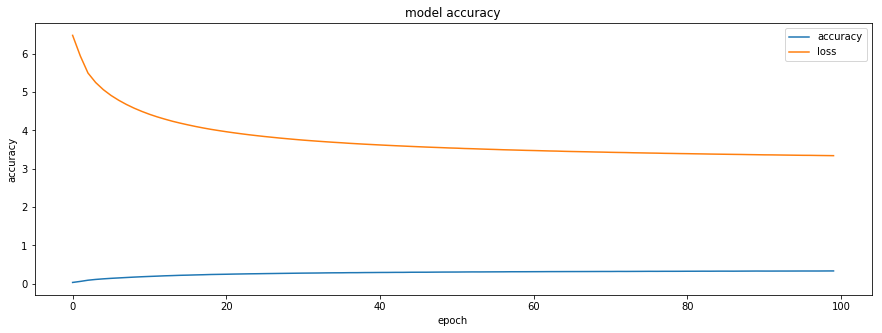

In [11]:
# Plota o gráfico do histórico do modelo
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

history = model.history

# Gráfico do histórico de treinamento
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.show()

In [12]:
# Salva o modelo em um binário
import joblib

joblib.dump(tokenizer, './model/tokenizer.bin')
joblib.dump(max_length, './model/max_length.bin')
joblib.dump(model, './model/sertanejoBot.bin')
print("Model Saved!")

Model Saved!
